# Import Packages

In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from geopy.geocoders import Nominatim
import requests

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error 
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from math import sqrt

from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.model_selection import cross_val_predict

# Read File

In [183]:
investments = pd.read_csv("220604_2100_master_Year_filtered.csv", sep=",", encoding = "ISO-8859-1")

In [4]:
raised_filtered = pd.read_csv("220604_1250_filtered_funding.csv", sep=",", encoding = "ISO-8859-1")

# Visualisation

To identify trends in the data. (numerical only with continent as the categorical variable)

- There are no obvious trends
- Data is not linearly related

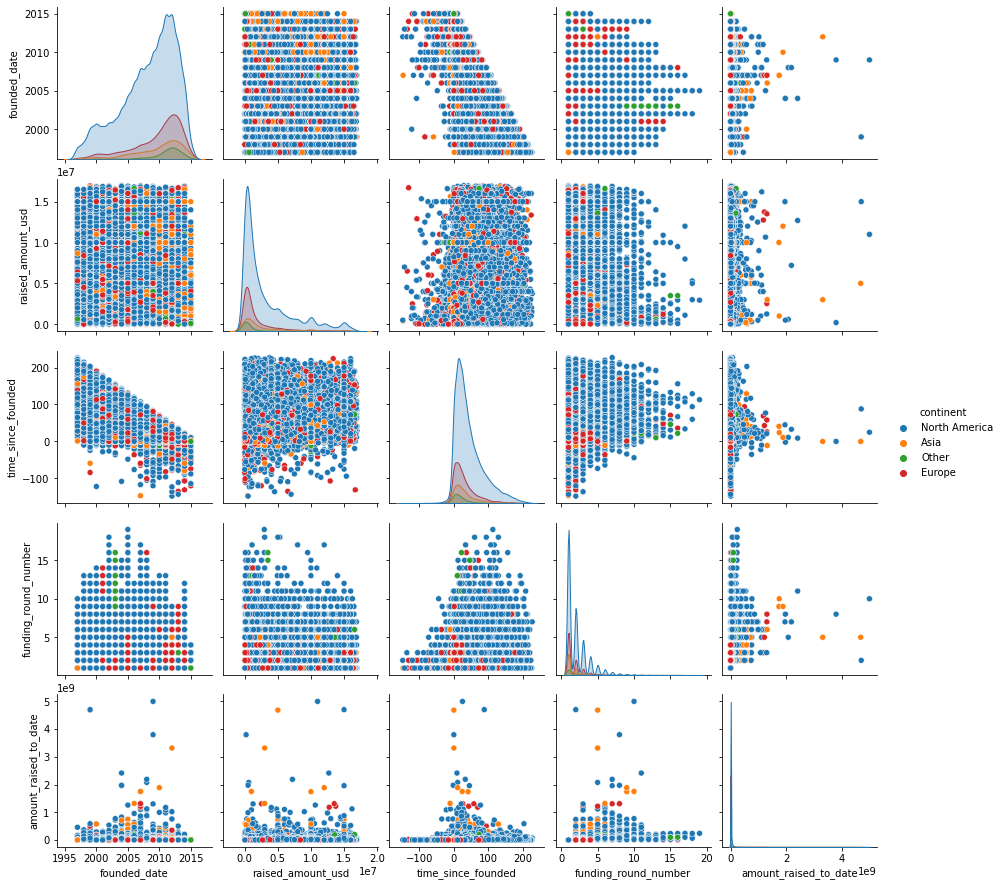

In [184]:
visual_plot = investments[['continent', 'founded_date', 'funded_at', 
                           'raised_amount_usd', 'status', 'time_since_founded',
                           'funding_round_number', 'amount_raised_to_date']]

sns.pairplot(visual_plot, hue='continent')

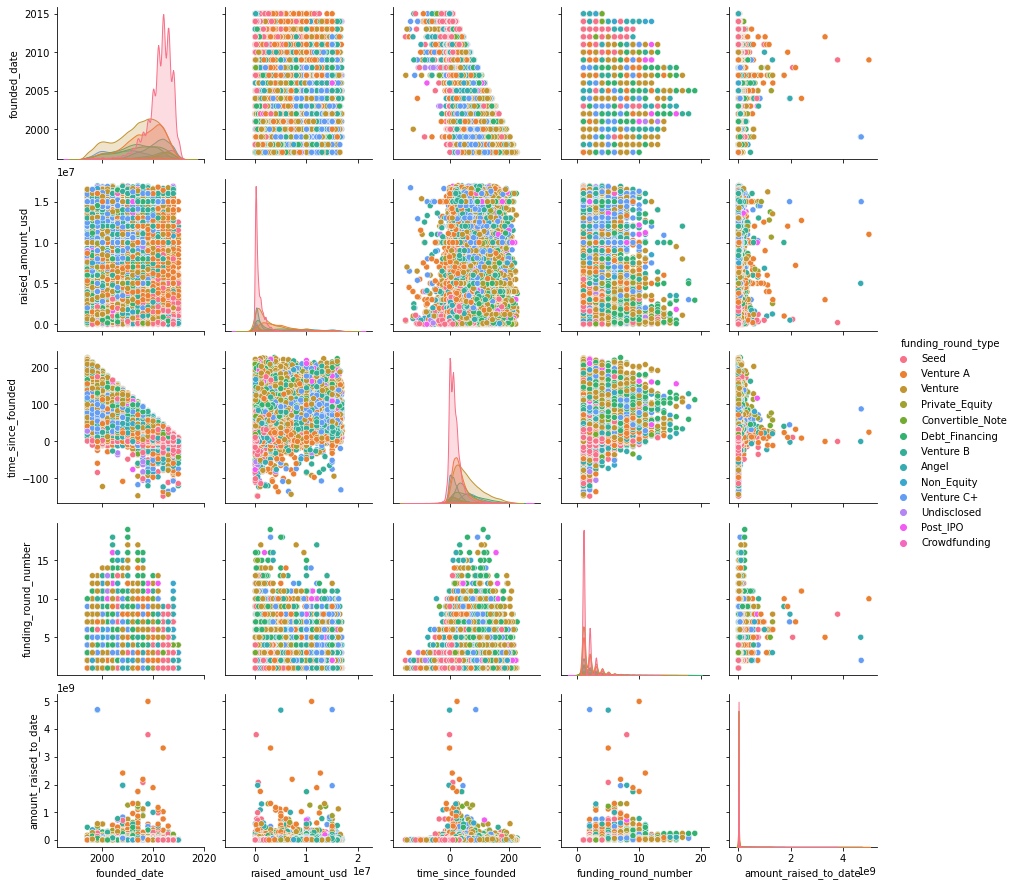

In [186]:
visual_plot_2 = investments[['funding_round_type', 'founded_date', 'funded_at', 
                           'raised_amount_usd', 'status', 'time_since_founded',
                           'funding_round_number', 'amount_raised_to_date']]

sns.pairplot(visual_plot_2, hue='funding_round_type')

# Encoding Categorical Data

As most categorical values consist of less than around 20 values, one hot encoding will be used. 

This will be done on the columns:
- continent
- status
- funding_round_type

This way, they can be treated as numerical variables where they take the value 1 if they take that class or 1 if they don't. 

In [123]:
# Continent
ohe = OneHotEncoder()

def ohe_feature(df, feature_list):
    for feature in feature_list:
        transformed_features = ohe.fit_transform(df[[feature]])
        features = ohe.categories_[0]
        df[features] = transformed_features.toarray()
    return df

In [91]:
# One hot encode variables
investments = ohe_feature(investments, ['continent', 'status', 'funding_round_type']) 

# Convert dates to year
investments['funded_at'] = pd.DatetimeIndex(investments['funded_at']).year

# Dropping Features

In [95]:
# Drop features which are independent to the amount raised and which contain categorical variables
investments = investments.drop(columns=[
    'city',
    'continent',
    'country_name',
    'funding_round_permalink', 
    'funding_round_type',
    'name', 
    'permalink', 
    'status', 
    'main_sector',
    'funding_round_code',
    'success'])

# Visualise

### Dataframe Before Removing Outliers:

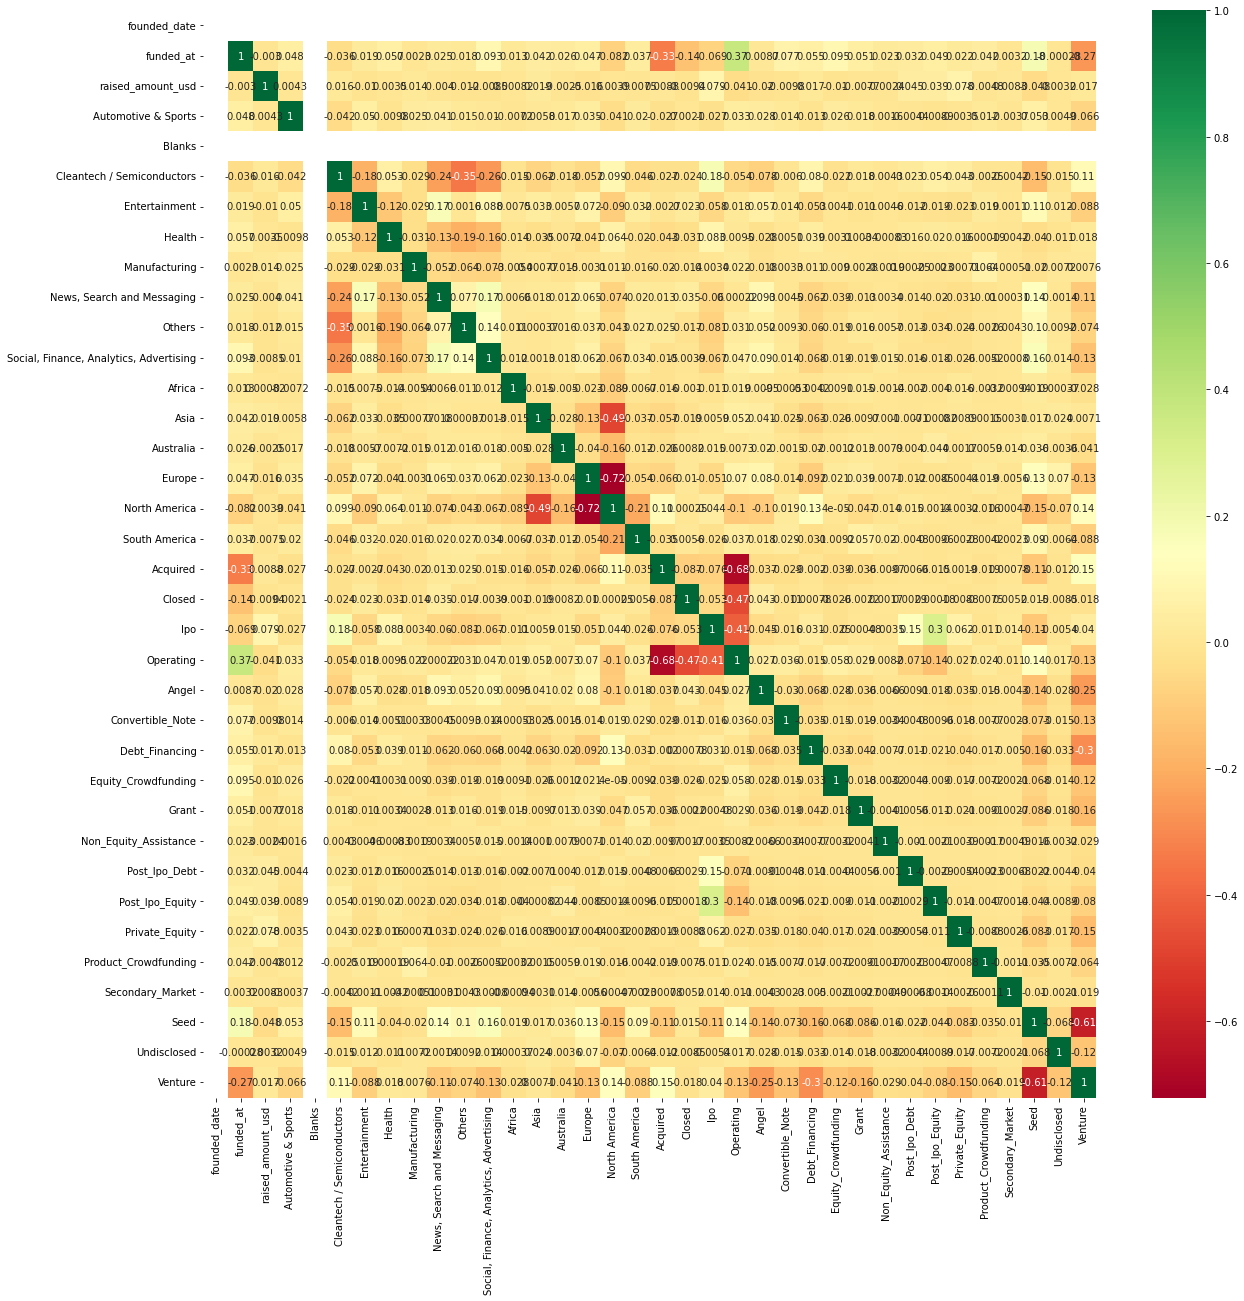

In [187]:
# All outliers
no_filter = pd.read_csv("merged_df.csv", sep=",", encoding = "ISO-8859-1")
no_filter = ohe_feature(no_filter, feats) 
# drop features
no_filter = no_filter.drop(columns=[
    'category_list', 'sector', 'time_from_founded', 'continent', 'country_name', 'funding_round_permalink', 'funding_round_type', 'name', 
    'permalink', 'status', 'main_sector'])
no_filter['funded_at'] = pd.DatetimeIndex(no_filter['funded_at']).year
no_filter['founded_date'] = pd.DatetimeIndex(no_filter['funded_at']).year
no_filter = no_filter.dropna()

#get correlations of each features in dataset
corrmat = no_filter.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
g=sns.heatmap(no_filter[top_corr_features].corr(),annot=True,cmap="RdYlGn")


### Dataframe after removing outliers

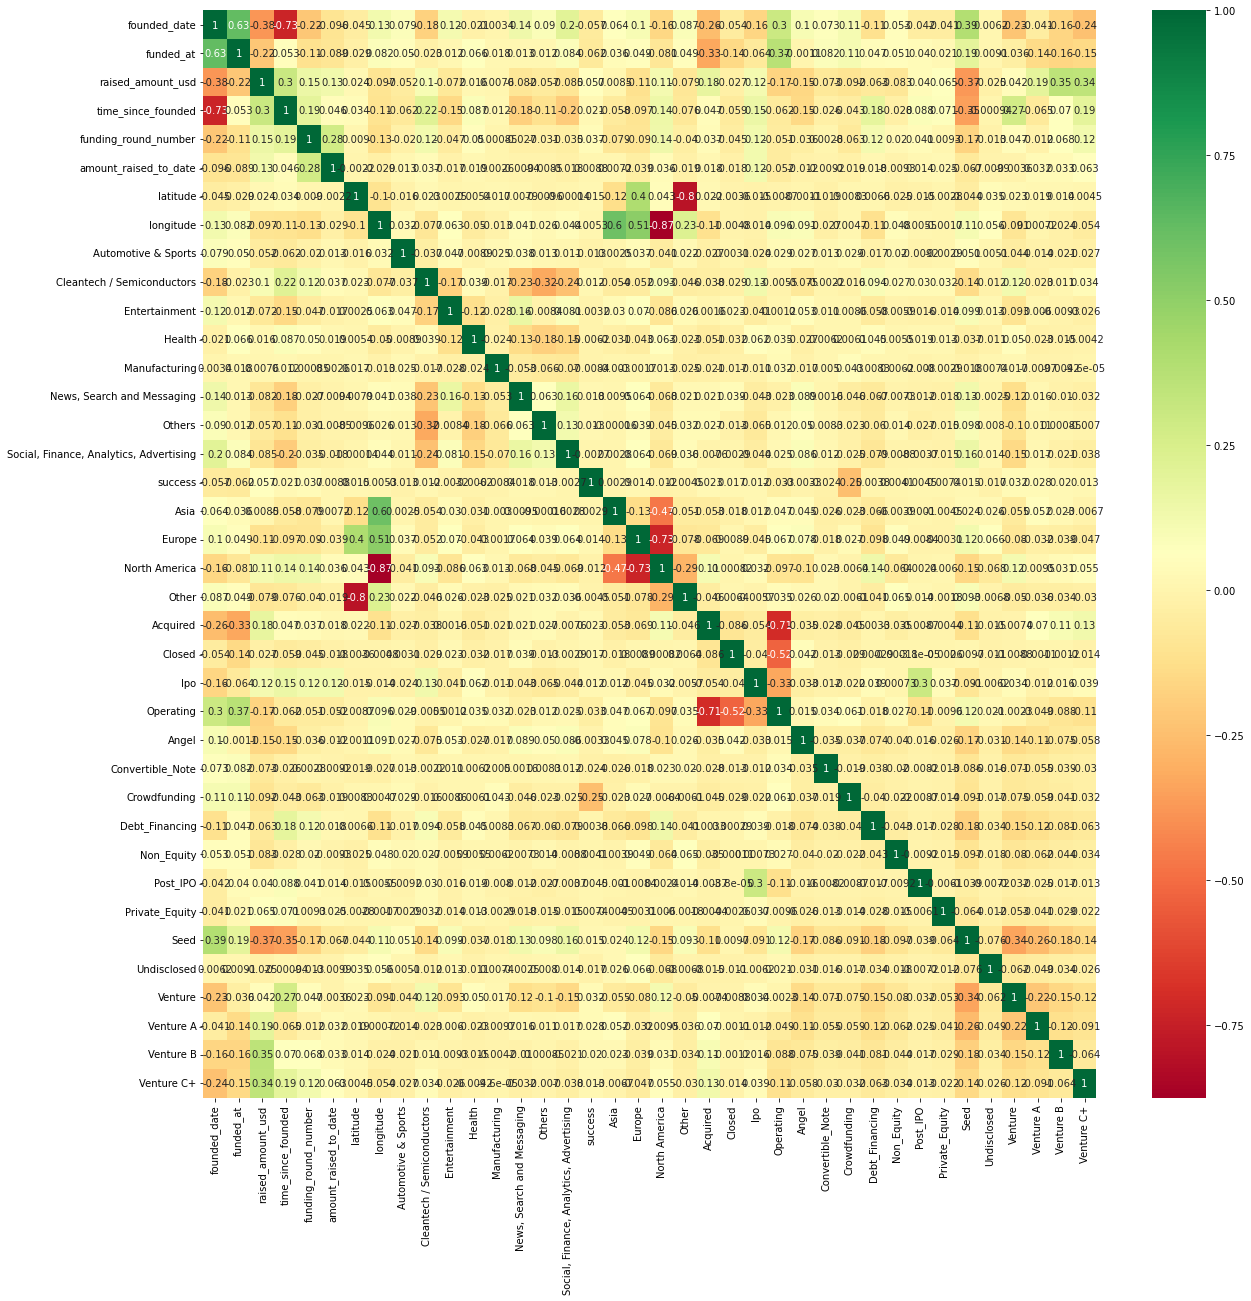

In [54]:
#get correlations of each features in dataset
corrmat = investments.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
g=sns.heatmap(investments[top_corr_features].corr(),annot=True,cmap="RdYlGn")

There are obviously more strong correlations between raised_amount_usd and other variables after removing outliers, however these are still not very strong. 

Let's visualise how they look on a scatter graph:

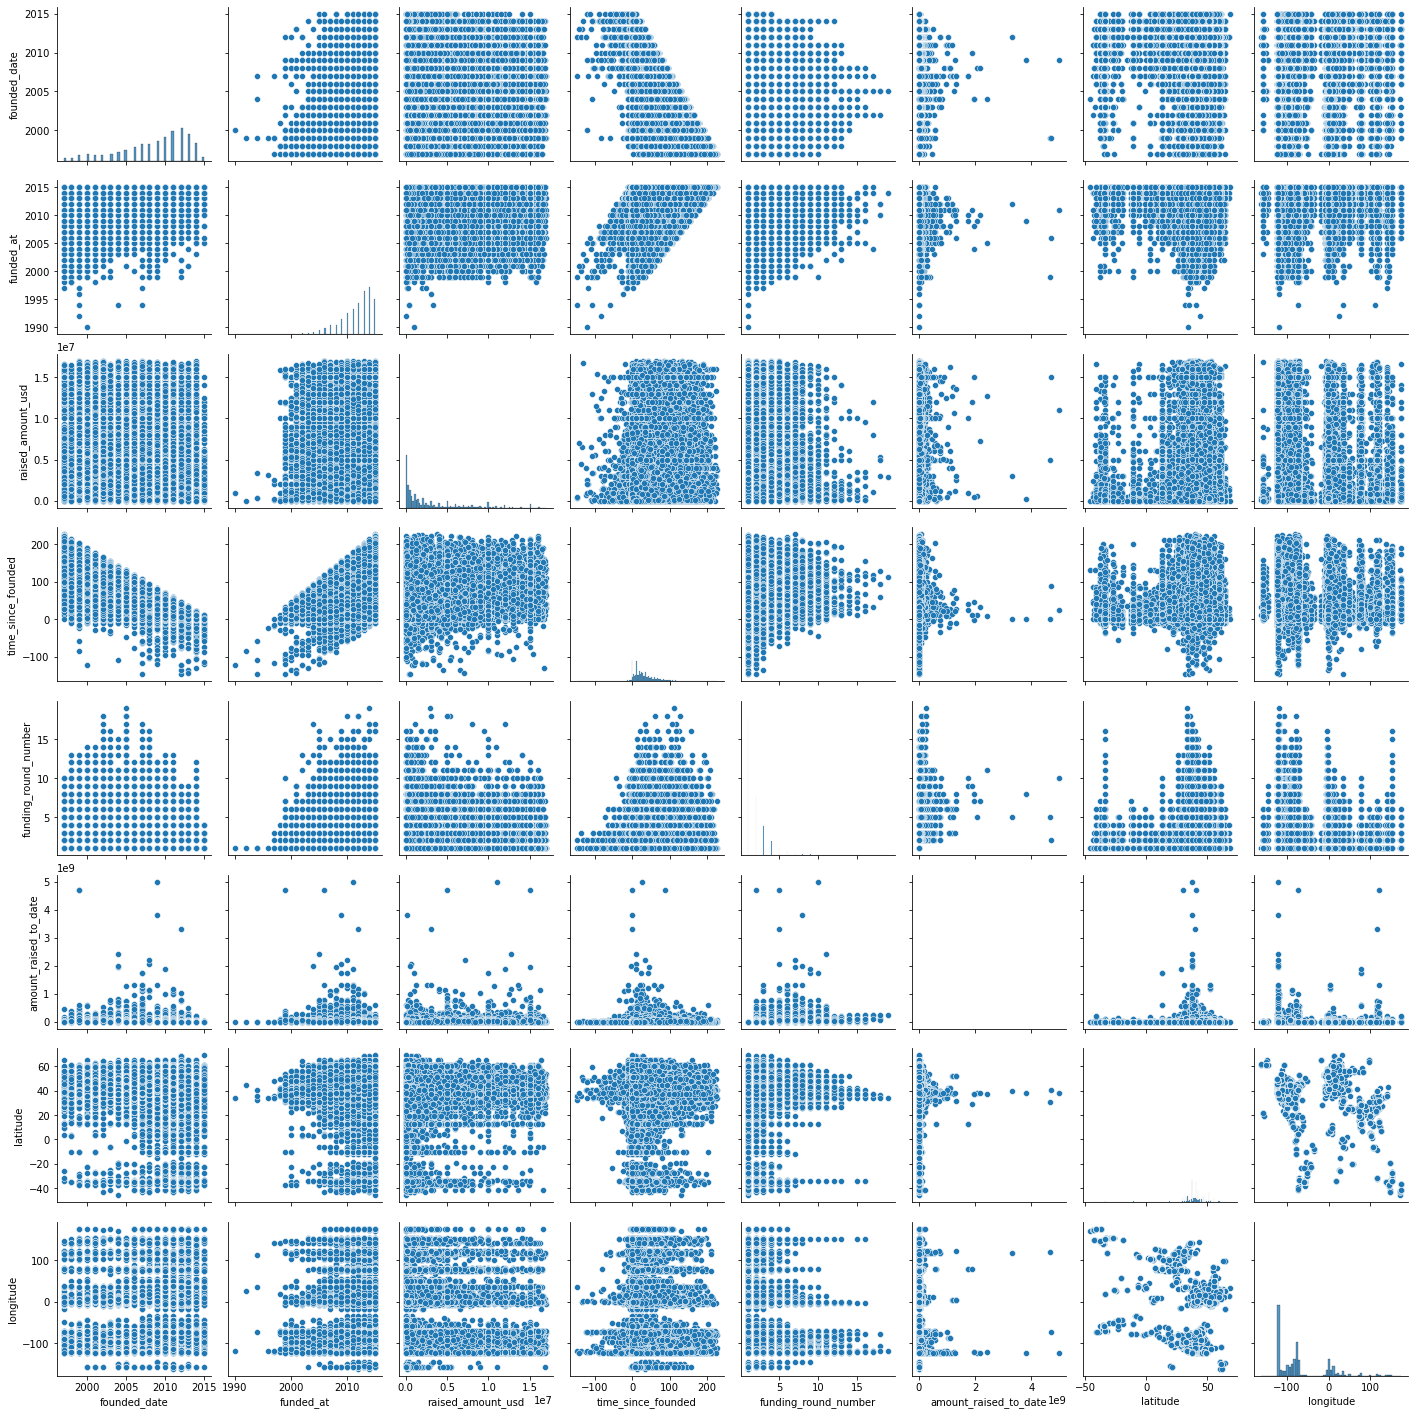

In [57]:
df = investments[['founded_date', 'funded_at', 'raised_amount_usd', 'time_since_founded',
       'funding_round_number', 'amount_raised_to_date', 'latitude',
       'longitude']]
sns.pairplot(df)

# Model Building

## First Model Attempt

A baseline model was built to start with. As more dataframes were cleaned and processed then exported from the analysis, the baseline model could be built on each of these. 

The model was built using K Nearest Neighbors. This was chosen as there was no polynomial or linear regression between any of the variables and it tends to work well when categorical data has been converted. Therefore there is no continuous line between whether a point belongs to a class or not. 

It looks for feature similarity, so will find other companies or investment rounds with similar properties and find the k nearest points to that and base the prediction off of them. 

There is still a lot of room for refinement with this model. 

#### Read the csv files and prepare them

In [195]:
feats = ['continent', 'status', 'funding_round_type']

# All outliers
no_filter = pd.read_csv("merged_df_CP4.csv", sep=",", encoding = "ISO-8859-1")
no_filter = ohe_feature(no_filter, feats) 

# Outliers from raised_amount_usd removed
funding_filter = pd.read_csv("220605_2125_filtered_funding.csv", sep=",", encoding = "ISO-8859-1")
funding_filter = ohe_feature(funding_filter, feats) 

# Outliers from raised_amount_usd and founded_date removed
year_filter = pd.read_csv("220605_2125_master_df.csv", sep=",", encoding = "ISO-8859-1")
year_filter = ohe_feature(year_filter, feats) 

In [196]:
# drop features
no_filter = no_filter.drop(columns=[
    'city', 'continent', 'country_name', 'funding_round_permalink', 'funding_round_type', 'name', 
    'permalink', 'status', 'main_sector'])

funding_filter = funding_filter.drop(columns=[
    'city', 'continent', 'country_name', 'funding_round_permalink', 'funding_round_type', 'name', 
    'permalink', 'status', 'main_sector', 'funding_round_code'])

year_filter = year_filter.drop(columns=[
    'city', 'continent', 'country_name', 'funding_round_permalink', 'funding_round_type', 'name', 
    'permalink', 'status', 'main_sector', 'funding_round_code'])

In [197]:
no_filter['funded_at'] = pd.DatetimeIndex(no_filter['funded_at']).year
no_filter['founded_date'] = pd.DatetimeIndex(no_filter['funded_at']).year

funding_filter['funded_at'] = pd.DatetimeIndex(funding_filter['funded_at']).year
funding_filter['founded_date'] = pd.DatetimeIndex(funding_filter['funded_at']).year

year_filter['funded_at'] = pd.DatetimeIndex(year_filter['funded_at']).year

In [198]:
no_filter = no_filter.dropna()
funding_filter = funding_filter.dropna()
no_filyear_filterter = year_filter.dropna()

#### Function to build the model
This is just based on a k number of 20 to start with as an estimator, just to compare how the models perform relative to one another. 

In [199]:
def run_knn(df, predictor, n):
    X = df.loc[:, df.columns != predictor]
    y = df[predictor]
    knn = KNeighborsRegressor(n_neighbors=n)
    y_pred = cross_val_predict(knn, X, y, cv=5) # cross validation foldsb
    rmse = sqrt(mean_squared_error(y,y_pred))
    r2 = r2_score(y,y_pred)
    return rmse, r2

In [200]:
pred = 'raised_amount_usd'
k = 20

no_filter_rmse, no_filter_r2 = run_knn(no_filter, pred, k)
funding_filter_rmse, funding_filter_r2 = run_knn(funding_filter, pred, k)
year_filter_rmse, year_filter_r2 = run_knn(year_filter, pred, k)

#### Compare the RMSE and R^2 Scores of the Models

In [201]:
print('RMSE \n', no_filter_rmse, 'when all outliers are left in\n', 
      funding_filter_rmse, 'when outliers in raised_amount_usd are removed\n',  
      year_filter_rmse, 'when outliers in raised_amount_usd and founded_date are removed')
print('\nR^2\n', no_filter_r2, 'when all outliers are left in',
     '\n', funding_filter_r2, 'when outliers in raised_amount_usd are removed', 
     '\n', year_filter_r2, 'when outliers in raised_amount_usd and founded_date are removed')

RMSE 
 117515235.0851465 when all outliers are left in
 3402994.5367839513 when outliers in raised_amount_usd are removed
 3363559.7499864465 when outliers in raised_amount_usd and founded_date are removed

R^2
 -0.012393396501785059 when all outliers are left in 
 0.25020871536279843 when outliers in raised_amount_usd are removed 
 0.2551222206514847 when outliers in raised_amount_usd and founded_date are removed


#### Build a model from the best performing dataframe above

Try a range of k values to find the best.

In [202]:
rmse_list = []
r2_list = []

for k in np.arange(1,51, 4):
    top_filter_rmse, top_filter_r2 = run_knn(year_filter, pred, k)
    rmse_list.append(top_filter_rmse)
    r2_list.append(top_filter_r2)

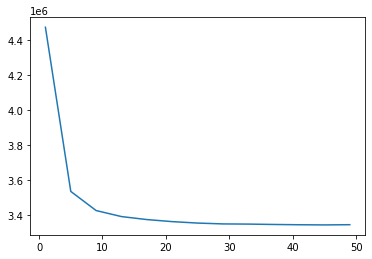

In [203]:
plt.plot(np.arange(1,51, 4), rmse_list)

In [204]:
tf_rmse, tf_r2 = run_knn(year_filter, pred, 40)

In [205]:
tf_rmse, tf_r2

(3343358.9433378708, 0.26404250048308053)

## KNN Regression - on numerical features

#### Normalized Data

In [98]:
# Create x and y variables
X = investments.loc[:, investments.columns != 'raised_amount_usd']  #independent columns
y = investments['raised_amount_usd']    #target column i.e price range

# Define the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

X = scaler.fit_transform(X)
# y = scaler.fit_transform(y)

# Create the train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [185]:
y_train.mean(), y_test.mean(), y_train.median(), y_test.median()

(2987721.781927361, 2968554.5054166666, 1200000.0, 1199286.0)

In [99]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 3851282.5367166596
RMSE value for k=  2 is: 3365649.354075264
RMSE value for k=  3 is: 3200396.3749837885
RMSE value for k=  4 is: 3110855.394747891
RMSE value for k=  5 is: 3049803.566211124
RMSE value for k=  6 is: 3007147.9647794105
RMSE value for k=  7 is: 2974753.592091244
RMSE value for k=  8 is: 2953970.071436747
RMSE value for k=  9 is: 2938618.4680433827
RMSE value for k=  10 is: 2933035.347525352
RMSE value for k=  11 is: 2925255.2961198986
RMSE value for k=  12 is: 2919747.7015914847
RMSE value for k=  13 is: 2912496.1207240843
RMSE value for k=  14 is: 2909127.237504751
RMSE value for k=  15 is: 2905994.81337546
RMSE value for k=  16 is: 2905217.362559199
RMSE value for k=  17 is: 2905506.472688113
RMSE value for k=  18 is: 2902497.3602201645
RMSE value for k=  19 is: 2900263.5202987636
RMSE value for k=  20 is: 2897490.1510049757


<AxesSubplot:>

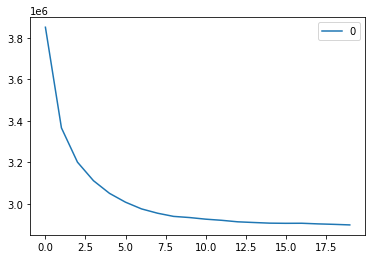

In [100]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

It seems like this could keep decreasing. Therefore, we'll try again with bigger intervals between k values. 

In [101]:
rmse_val = [] #to store rmse values for different k
for K in np.arange(0, 100, 10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 3851282.5367166596
RMSE value for k=  11 is: 2925255.2961198986
RMSE value for k=  21 is: 2896916.1009191824
RMSE value for k=  31 is: 2885883.318199768
RMSE value for k=  41 is: 2884130.591899456
RMSE value for k=  51 is: 2883002.418015512
RMSE value for k=  61 is: 2885847.936882284
RMSE value for k=  71 is: 2886911.309648314
RMSE value for k=  81 is: 2890412.3731532064
RMSE value for k=  91 is: 2891463.8001447273


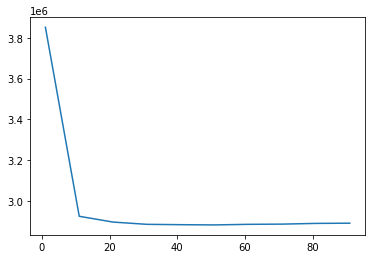

In [107]:
#plotting the rmse values against k values
k_range = np.arange(1, 100, 10)
plt.plot(k_range, rmse_val)

We can be comfortable with a k value of 40, as it flattens out at this value. Next let's find the R^2 error. 

In [109]:
model = neighbors.KNeighborsRegressor(n_neighbors = 40)
model.fit(X_train, y_train)  #fit the model
pred = model.predict(X_test) #make prediction on test set
rmse_error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
r2_error = r2_score(y_test,pred)
print('RMSE value is:', rmse_error)
print('R^2 value is:', r2_error)

RMSE value is: 2884308.436427369
R^2 value is: 0.4475329728394414


### Scaling

https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/

In [110]:
standard_data = investments

In [112]:
# Create x and y variables
X = standard_data.loc[:, standard_data.columns != 'raised_amount_usd']  #independent columns
y = standard_data['raised_amount_usd']    #target column i.e price range

# Define the scaler
scaler = StandardScaler()

X = scaler.fit_transform(X)
# y = scaler.fit_transform(y)

# Create the train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [114]:
rmse_val_standard = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val_standard.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 3802803.4137801942
RMSE value for k=  2 is: 3336369.8705322566
RMSE value for k=  3 is: 3147760.1144501045
RMSE value for k=  4 is: 3065130.3228020063
RMSE value for k=  5 is: 3016110.567538809
RMSE value for k=  6 is: 2978963.0262064934
RMSE value for k=  7 is: 2957178.83717915
RMSE value for k=  8 is: 2941722.1463511437
RMSE value for k=  9 is: 2931789.7956743916
RMSE value for k=  10 is: 2915642.5209140503
RMSE value for k=  11 is: 2910097.5208016434
RMSE value for k=  12 is: 2904430.0346580734
RMSE value for k=  13 is: 2903153.4389854525
RMSE value for k=  14 is: 2897212.336037164
RMSE value for k=  15 is: 2894840.0358662824
RMSE value for k=  16 is: 2891462.1676013446
RMSE value for k=  17 is: 2886755.289348743
RMSE value for k=  18 is: 2886313.7217989983
RMSE value for k=  19 is: 2884644.12808225
RMSE value for k=  20 is: 2883129.7771134865


In [115]:
rmse_val_standard = [] #to store rmse values for different k
for K in np.arange(0, 100, 10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val_standard.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 3802803.4137801942
RMSE value for k=  11 is: 2910097.5208016434
RMSE value for k=  21 is: 2882443.6262065675
RMSE value for k=  31 is: 2879600.322114002
RMSE value for k=  41 is: 2879533.36248689
RMSE value for k=  51 is: 2878164.2884731116
RMSE value for k=  61 is: 2879443.29117185
RMSE value for k=  71 is: 2881396.052556051
RMSE value for k=  81 is: 2883985.1443319963
RMSE value for k=  91 is: 2885837.0230489355


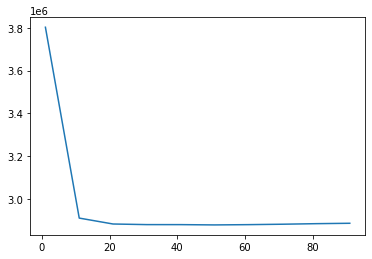

In [117]:
#plotting the rmse values against k values
k_range = np.arange(1, 100, 10)
plt.plot(k_range, rmse_val_standard)

In [116]:
model = neighbors.KNeighborsRegressor(n_neighbors = 50)
model.fit(X_train, y_train)  #fit the model
pred = model.predict(X_test) #make prediction on test set
rmse_error_standard = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
r2_error_standard = r2_score(y_test,pred)
print('RMSE value is:', rmse_error_standard)
print('R^2 value is:', r2_error_standard)

RMSE value is: 2877983.818933411
R^2 value is: 0.44926618838911736


# Historic Attempts

Tried as practice and tests before the models above.

## Polynomial Regression Model

As can be seen above there is very little correlation between the variables that can then be converted to a polynomial relationship. Therefore the following model was created more for practice. 

In [12]:
# Create a simple polynomial regression model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

X = investments.loc[:, investments.columns != 'raised_amount_usd']
y = investments['raised_amount_usd']

poly = PolynomialFeatures(degree=1, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
from sklearn.metrics import mean_squared_error
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
print(poly_reg_rmse)
print(r2_score(y_test,poly_reg_y_predicted))

2952710.550987974
0.4308023302602233


In [11]:
# Create a simple polynomial regression model
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

X = investments.loc[:, investments.columns != 'raised_amount_usd']
y = investments['raised_amount_usd']

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)

poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)

poly_reg_y_predicted = poly_reg_model.predict(X_test)
from sklearn.metrics import mean_squared_error
poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
print(poly_reg_rmse)
print(r2_score(y_test,poly_reg_y_predicted))

3207750.5090186917
0.32822702771391565


### Remove Features

In [15]:
investments.columns

Index(['founded_date', 'funded_at', 'raised_amount_usd', 'time_since_founded',
       'funding_round_number', 'amount_raised_to_date', 'latitude',
       'longitude', 'Automotive & Sports', 'Cleantech / Semiconductors',
       'Entertainment', 'Health', 'Manufacturing',
       'News, Search and Messaging', 'Others',
       'Social, Finance, Analytics, Advertising', 'success', 'Asia', 'Europe',
       'North America', 'Other', 'Acquired', 'Closed', 'Ipo', 'Operating',
       'Angel', 'Convertible_Note', 'Crowdfunding', 'Debt_Financing',
       'Non_Equity', 'Post_IPO', 'Private_Equity', 'Seed', 'Undisclosed',
       'Venture', 'Venture A', 'Venture B', 'Venture C+'],
      dtype='object')

In [60]:
column_names = ['founded_date', 'funded_at',
       'funding_round_number', 'amount_raised_to_date', 'latitude',
       'longitude', 'Automotive & Sports', 'Cleantech / Semiconductors',
       'Entertainment', 'Health', 'Manufacturing',
       'News, Search and Messaging', 'Others',
       'Social, Finance, Analytics, Advertising', 'success', 'Asia', 'Europe',
       'North America', 'Other', 'Acquired', 'Closed', 'Ipo', 'Operating',
       'Angel', 'Convertible_Note', 'Crowdfunding', 'Debt_Financing',
       'Non_Equity', 'Post_IPO', 'Private_Equity', 'Seed', 'Undisclosed',
       'Venture', 'Venture A', 'Venture B', 'Venture C+']

rmse = []
r2 = []

for feature in column_names:
    test = investments.drop(columns=feature)
    X = test.loc[:, test.columns != 'raised_amount_usd']    
    y = test['raised_amount_usd']    #target column i.e price range

    poly = PolynomialFeatures(degree=2, include_bias=False)
    poly_features = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=42)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(X_train, y_train)

    poly_reg_y_predicted = poly_reg_model.predict(X_test)
    poly_reg_rmse = np.sqrt(mean_squared_error(y_test, poly_reg_y_predicted))
    poly_r2_score = r2_score(y_test,poly_reg_y_predicted)
    
    rmse.append(poly_reg_rmse)
    r2.append(poly_r2_score)
    
print(rmse)
print(r2)

[3116719.0561958198, 2987228.354511805, 2949107.304754629, 2906451.093096455, 2966072.5947344187, 2964183.2717844085, 3224984.6191732404, 3213340.11970417, 3236793.256386475, 3197356.0281178076, 2970025.3038864033, 3322180.0613127546, 2970596.1563133323, 2952818.6259618434, 3205931.50360424, 3212502.9939012933, 3213771.357352678, 3215946.3896086635, 3210164.4457497783, 3215081.9133594846, 3264434.916586009, 3209771.8452037587, 2965664.3045516512, 3248066.6212543384, 3139235.111123128, 3122517.1306809653, 3231475.927178077, 3188506.1511440217, 2964337.9553636154, 3177970.564603978, 3286839.7809407883, 3197549.8954854887, 2959865.892891943, 3203222.446037437, 3202044.250691827, 3396789.5481090397]
[0.3658139652751806, 0.4174164636761908, 0.4321906871023, 0.44849760786258663, 0.4256390383449863, 0.4263705158812904, 0.32098923909179944, 0.32588381496411234, 0.3160075896049701, 0.33257363621447555, 0.4241071846953294, 0.2794440704582214, 0.42388578496217233, 0.43076066200454777, 0.328988690

In [63]:
pr_error = pd.DataFrame()
pr_error['feature'] = column_names
pr_error['rmse'] = rmse
pr_error['r2'] = r2

Text(0.5, 1.0, 'R^2 Score After Removing each Feature')

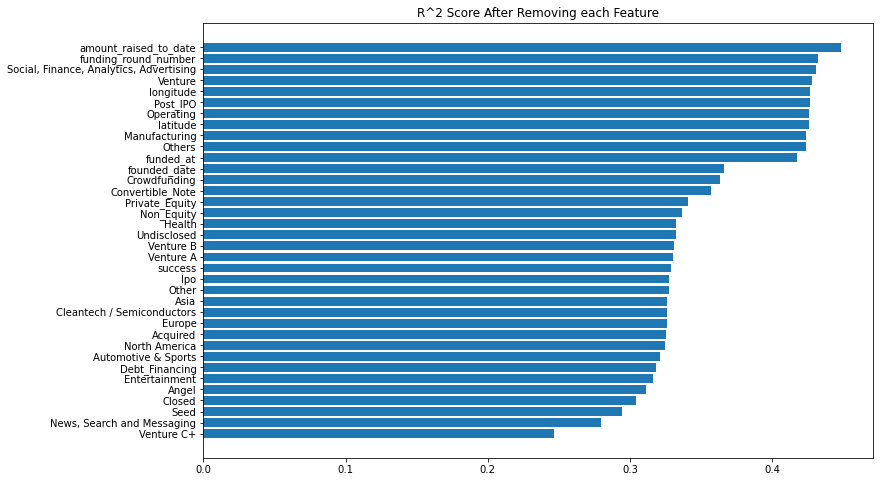

In [67]:
pr_error = pr_error.sort_values(by='r2')

plt.figure(figsize=(12,8))
plt.barh(pr_error['feature'], pr_error['r2'])
plt.title('R^2 Score After Removing each Feature')

This suggests that the amount raised to date and the funding round number are not important. Equally the longitude and latitude and several funding round types are not very important.

This means the location could be grouped more, as it has been by continents. The investment round type could also be grouped more, as some have a bigger impact on the outcome i.e. whether the funding type is Venture C+ or Angel. Equally, investments are lower for companies which are no longer operating.

## RFR

This was explored a bit but needs to be run and refined properly. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Instantiate random forest regressor
rf = RandomForestRegressor(random_state=42)

In [ ]:
# Fit the random forest model to the training data
rfModel = rf.fit(X_train, y_train)

In [ ]:
# Do prediction using our data
y_pred_r = rfModel.predict(X_test)

In [ ]:
mae_r = mean_absolute_error(y_test, y_pred_r)
mse_r = mean_squared_error(y_test, y_pred_r)

print(mae_r, mse_r)